In this Notebook I will show how to solve CIFAR10 dataset with Convolutional Neural Network.

### Import

In [1]:
!pip install -q keras
import keras
from keras.models import Sequential
from keras.layers import Activation, Conv2D, MaxPool2D, Dense, Flatten, Dropout
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.initializers import glorot_uniform
from keras.datasets import cifar10

import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

import os
import random as rn
import numpy as np

# Randomness control
os.environ['PYTHONHASHSEED'] = '0'
RANDOM_SEED = 3939
np.random.seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, 
                              inter_op_parallelism_threads=1)

tf.set_random_seed(RANDOM_SEED)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
keras.backend.set_session(sess)

Using TensorFlow backend.


### Constants

In [0]:
CLASS_NUMBER = 10

IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
NUM_CHANNELS = 3

TRAIN_IMAGE_NUMBER = 50000
TEST_IMAGE_NUMBER = 10000

### Loading Data

Fashion MNIST data is being built into ``from keras.datasets`` module.

In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

 42115072/170498071 [======>.......................] - ETA: 2:21

170500096/170498071 [==============================] - 136s 1us/step


### Data Visualisation

In [0]:
def show_images(X_train, y_train, rows_num=6):    
    figure, axes = plt.subplots(nrows=rows_num, ncols=6, sharex=True, sharey=True, figsize=(20, rows_num * 2))
    
    for row_index in range(rows_num):
        ax_row = axes[row_index]
        images = X_train[(row_index*8):(row_index+1)*8]
        labels = y_train[(row_index*8):(row_index+1)*8]
        
        for ax, img, label in zip(ax_row, images, labels):
            ax.imshow(img)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            ax.set_title("Label - {}".format(label))

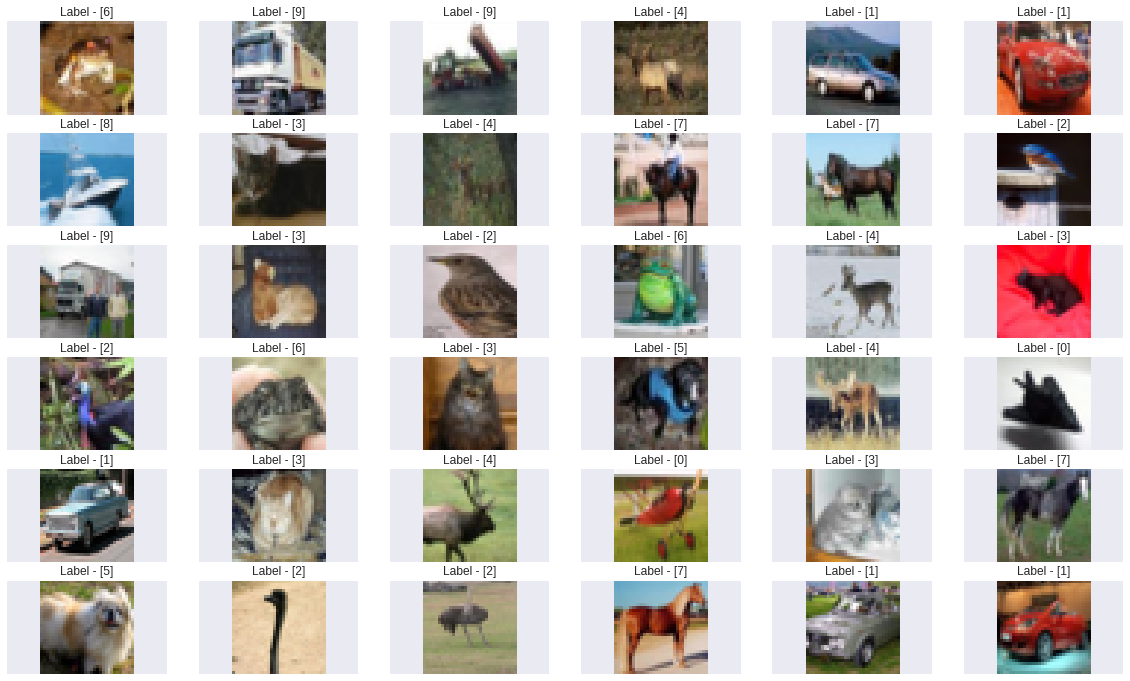

In [5]:
show_images(X_train, y_train)

### Data Preprocessing

Normalization

In [6]:
print("Training data - before normalization: ")
print(" - min: {}".format(X_train.min()))
print(" - max: {}".format(X_train.max()))
print("Test data - after normalization: ")
print(" - min: {}".format(X_test.min()))
print(" - max: {}".format(X_test.max()))

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

print("\nTraining data - after normalization: ")
print(" - min: {}".format(X_train.min()))
print(" - max: {}".format(X_train.max()))
print("Test data - after normalization: ")
print(" - min: {}".format(X_test.min()))
print(" - max: {}".format(X_test.max()))

Training data - before normalization: 
 - min: 0
 - max: 255
Test data - after normalization: 
 - min: 0
 - max: 255

Training data - after normalization: 
 - min: 0.0
 - max: 1.0
Test data - after normalization: 
 - min: 0.0
 - max: 1.0


One-Hot Encoding

In [7]:
print("Train data labels - before OHE: ")
print(" - example: {}\n".format(y_train[:10]))
print("Test data labels - before OHE: ")
print(" - example: {}\n".format(y_test[:10]))

y_train = keras.utils.to_categorical(y_train, CLASS_NUMBER)
y_test = keras.utils.to_categorical(y_test, CLASS_NUMBER)

print("\nTrain data labels - after OHE: ")
print(" - example: \n{}".format(y_train[:10]))
print("Test data labels - after OHE: ")
print(" - example: \n{}".format(y_test[:10]))

Train data labels - before OHE: 
 - example: [[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]]

Test data labels - before OHE: 
 - example: [[3]
 [8]
 [8]
 [0]
 [6]
 [6]
 [1]
 [6]
 [3]
 [1]]


Train data labels - after OHE: 
 - example: 
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
Test data labels - after OHE: 
 - example: 
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


### Train/Validation data split

In [8]:
split_ratio = 0.8
split_index = int(X_train.shape[0] * split_ratio)

X_train_input, y_train_input = X_train[:split_index], y_train[:split_index]
X_val_input, y_val_input = X_train[split_index:], y_train[split_index:]

print("X_train_input shape: {}".format(X_train_input.shape))
print("y_train_input shape: {}".format(y_train_input.shape))
print("X_val_input shape: {}".format(X_val_input.shape))
print("y_val_input shape: {}".format(y_val_input.shape))

X_train_input shape: (40000, 32, 32, 3)
y_train_input shape: (40000, 10)
X_val_input shape: (10000, 32, 32, 3)
y_val_input shape: (10000, 10)


### Model

Creation

In [9]:
model = Sequential()

model.add(Conv2D(64, kernel_size=(3, 3), padding="same", use_bias=False,
                 input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, NUM_CHANNELS),
                 kernel_initializer=glorot_uniform(seed=RANDOM_SEED)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(64, kernel_size=(3, 3), padding="same", use_bias=False,
                 kernel_initializer=glorot_uniform(seed=RANDOM_SEED)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), padding="same", use_bias=False,
                 kernel_initializer=glorot_uniform(seed=RANDOM_SEED)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.4, seed=RANDOM_SEED))
model.add(Conv2D(128, kernel_size=(3, 3), padding="same", use_bias=False,
                 kernel_initializer=glorot_uniform(seed=RANDOM_SEED)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(256, kernel_size=(3, 3), padding="same", use_bias=False,
                 kernel_initializer=glorot_uniform(seed=RANDOM_SEED)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(256, kernel_size=(3, 3), padding="same", use_bias=False,
                 kernel_initializer=glorot_uniform(seed=RANDOM_SEED)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(512, kernel_size=(3, 3), padding="same", use_bias=False,
                 kernel_initializer=glorot_uniform(seed=RANDOM_SEED)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(512, kernel_size=(3, 3), padding="same", use_bias=False,
                 kernel_initializer=glorot_uniform(seed=RANDOM_SEED)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(512, kernel_size=(3, 3), padding="same", use_bias=False,
                 kernel_initializer=glorot_uniform(seed=RANDOM_SEED)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(512, kernel_size=(3, 3), padding="same", use_bias=False,
                 kernel_initializer=glorot_uniform(seed=RANDOM_SEED)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512, use_bias=False, 
                kernel_initializer=glorot_uniform(seed=RANDOM_SEED)))
model.add(BatchNormalization())
model.add(Activation("relu"))


model.add(Dense(CLASS_NUMBER, 
                activation="softmax",
                kernel_initializer=glorot_uniform(seed=RANDOM_SEED)))
    
model.compile(loss="categorical_crossentropy", optimizer=Adam(0.001), 
              metrics=["accuracy"])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1728      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        36864     
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
__________

Training

In [10]:
history = model.fit(X_train_input, y_train_input,
                    batch_size=64,
                    epochs=100,
                    verbose=2,
                    validation_data=(X_val_input, y_val_input))

Train on 40000 samples, validate on 10000 samples
Epoch 1/100
 - 72s - loss: 1.3052 - acc: 0.5264 - val_loss: 1.8282 - val_acc: 0.4320
Epoch 2/100
 - 69s - loss: 0.8541 - acc: 0.7009 - val_loss: 1.2928 - val_acc: 0.5945
Epoch 3/100
 - 69s - loss: 0.6749 - acc: 0.7661 - val_loss: 0.9938 - val_acc: 0.6817
Epoch 4/100
 - 69s - loss: 0.5573 - acc: 0.8084 - val_loss: 0.8048 - val_acc: 0.7393
Epoch 5/100
 - 69s - loss: 0.4573 - acc: 0.8424 - val_loss: 0.7949 - val_acc: 0.7426
Epoch 6/100
 - 69s - loss: 0.3737 - acc: 0.8696 - val_loss: 0.7550 - val_acc: 0.7607
Epoch 7/100
 - 69s - loss: 0.3064 - acc: 0.8939 - val_loss: 0.7805 - val_acc: 0.7705
Epoch 8/100
 - 69s - loss: 0.2402 - acc: 0.9169 - val_loss: 1.2098 - val_acc: 0.6879
Epoch 9/100
 - 69s - loss: 0.1908 - acc: 0.9342 - val_loss: 0.8553 - val_acc: 0.7725
Epoch 10/100
 - 69s - loss: 0.1513 - acc: 0.9473 - val_loss: 1.0701 - val_acc: 0.7284
Epoch 11/100
 - 69s - loss: 0.1269 - acc: 0.9560 - val_loss: 0.7314 - val_acc: 0.8156
Epoch 12/100


 - 69s - loss: 0.0232 - acc: 0.9926 - val_loss: 0.8827 - val_acc: 0.8330
Epoch 35/100
 - 69s - loss: 0.0249 - acc: 0.9921 - val_loss: 0.9795 - val_acc: 0.8223
Epoch 36/100
 - 69s - loss: 0.0268 - acc: 0.9913 - val_loss: 0.9192 - val_acc: 0.8235
Epoch 37/100
 - 69s - loss: 0.0215 - acc: 0.9928 - val_loss: 1.0015 - val_acc: 0.8056
Epoch 38/100
 - 69s - loss: 0.0215 - acc: 0.9929 - val_loss: 1.1370 - val_acc: 0.8022
Epoch 39/100
 - 69s - loss: 0.0241 - acc: 0.9923 - val_loss: 0.9488 - val_acc: 0.8369
Epoch 40/100
 - 69s - loss: 0.0187 - acc: 0.9935 - val_loss: 0.8940 - val_acc: 0.8404
Epoch 41/100
 - 69s - loss: 0.0208 - acc: 0.9929 - val_loss: 0.9690 - val_acc: 0.8365
Epoch 42/100
 - 69s - loss: 0.0212 - acc: 0.9928 - val_loss: 0.9247 - val_acc: 0.8371
Epoch 43/100
 - 69s - loss: 0.0185 - acc: 0.9933 - val_loss: 0.9106 - val_acc: 0.8379
Epoch 44/100
 - 70s - loss: 0.0172 - acc: 0.9940 - val_loss: 1.0786 - val_acc: 0.8140
Epoch 45/100
 - 70s - loss: 0.0214 - acc: 0.9935 - val_loss: 0.9019

 - 70s - loss: 0.0125 - acc: 0.9961 - val_loss: 0.9765 - val_acc: 0.8478
Epoch 69/100
 - 70s - loss: 0.0084 - acc: 0.9973 - val_loss: 0.9879 - val_acc: 0.8449
Epoch 70/100
 - 70s - loss: 0.0149 - acc: 0.9954 - val_loss: 0.9491 - val_acc: 0.8444
Epoch 71/100
 - 70s - loss: 0.0089 - acc: 0.9969 - val_loss: 0.9247 - val_acc: 0.8472
Epoch 72/100
 - 70s - loss: 0.0091 - acc: 0.9971 - val_loss: 0.8980 - val_acc: 0.8467
Epoch 73/100
 - 70s - loss: 0.0127 - acc: 0.9962 - val_loss: 0.8754 - val_acc: 0.8565
Epoch 74/100
 - 70s - loss: 0.0097 - acc: 0.9968 - val_loss: 0.9304 - val_acc: 0.8423
Epoch 75/100
 - 70s - loss: 0.0109 - acc: 0.9964 - val_loss: 0.9655 - val_acc: 0.8402
Epoch 76/100
 - 70s - loss: 0.0093 - acc: 0.9968 - val_loss: 0.9329 - val_acc: 0.8425
Epoch 77/100
 - 70s - loss: 0.0128 - acc: 0.9959 - val_loss: 0.9610 - val_acc: 0.8467
Epoch 78/100
 - 70s - loss: 0.0101 - acc: 0.9969 - val_loss: 0.9612 - val_acc: 0.8392
Epoch 79/100
 - 70s - loss: 0.0067 - acc: 0.9977 - val_loss: 0.9302

Evaluation

In [11]:
train_score = model.evaluate(X_train_input, y_train_input, verbose=0)
val_score = model.evaluate(X_val_input, y_val_input, verbose=0)
test_score = model.evaluate(X_test, y_test, verbose=0)
  
train_score, train_accuracy = train_score
print("Train data results:")
print(" - error: {}".format(train_score))
print(" - acc: {}".format(train_accuracy))

val_score, val_accuracy = val_score
print("Validation data results:")
print(" - error: {}".format(val_score))
print(" - acc: {}".format(val_accuracy))

test_score, test_accuracy = test_score
print("Test data results:")
print(" - error: {}".format(test_score))
print(" - acc: {}".format(test_accuracy))

Train data results:
 - error: 0.0022778310039126156
 - acc: 0.999125
Validation data results:
 - error: 0.9228373393774033
 - acc: 0.8524
Test data results:
 - error: 0.950111536937952
 - acc: 0.8499


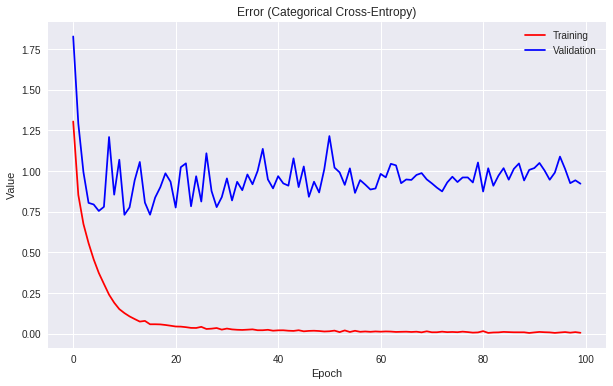

In [12]:
f, ax = plt.subplots()
f.set_size_inches(10, 6)
    
ax.plot(history.history["loss"], c="r")
ax.plot(history.history["val_loss"], c="b")
ax.set_title("Error (Categorical Cross-Entropy)")
ax.set_ylabel("Value")
ax.set_xlabel("Epoch")
ax.legend(["Training", "Validation"], loc="best");